In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import admix
from admix.data import zsc2pval, pval2chisq
from utils import load_r2_result, plot_heatmap, plot_heatmap2
from statsmodels.stats.multitest import multipletests
import matplotlib
from tqdm import tqdm

matplotlib.rcParams["font.family"] = ["Liberation Sans"]
import seaborn as sns

# Meta information

In [2]:
if True:
    DATA_URL = "https://www.dropbox.com/s/wpiio3t0lxkhn0d/data-table.xlsx?dl=1"
    !wget {DATA_URL} -O ./data-table.xlsx

--2022-11-06 13:42:48--  https://www.dropbox.com/s/wpiio3t0lxkhn0d/data-table.xlsx?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/wpiio3t0lxkhn0d/data-table.xlsx [following]
--2022-11-06 13:42:48--  https://www.dropbox.com/s/dl/wpiio3t0lxkhn0d/data-table.xlsx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3f485f51f1850898b879722cea.dl.dropboxusercontent.com/cd/0/get/BwT9JwJfY5qvGva1B7fqncORgbCDj2vTQAPQQIR5KOjHIf9Cs6an-GkaSpTRUuVGONWeCr_ys3vD4Evc7JsprntJU_CV0dRvmz02o2_-YLU3TrwJ0IctpHcCaBM_dAezQb7iB0PYhXbO998IjlmpeZ_fHAv3NP3Dmk__dmsJMVkJKWEw5qL_5_7E7DpvB-jB8vc/file?dl=1# [following]
--2022-11-06 13:42:48--  https://uc3f485f51f1850898b879722cea.dl.dropboxusercontent.com/cd/0/get/BwT9JwJfY5qvGva1B7fqncORgbCDj2vTQAPQQIR5KOjHIf9C

In [2]:
DATA_URL = "./data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}
covar_map = {
    "AGE": "Age",
    "SEX": "Sex",
    "PC1": "PC1",
    "PC2": "PC2",
    "PC3": "PC3",
    "PC4": "PC4",
    "log_BMI": "BMI",
    "ever_smoked": "Smoking",
    "drink_alcohol": "Alcohol",
    "glasses": "Wear glasses",
    "income": "Income",
    "DEPRIVATION_INDEX": "Deprivation index",
    "years_of_edu": "Edu years",
}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

In [3]:
df_baseline_wb = load_r2_result(result_dir=f"out/", group="white")[0]
df_baseline_other = load_r2_result(result_dir=f"out/", group="other")[0]
df_baseline_all = load_r2_result(result_dir=f"out/", group="all")[0]

trait_list = list(df_baseline_wb.index[df_baseline_wb > 0.05])
print(
    f"Retaining {len(trait_list)}/{len(df_baseline_wb)} traits have R2 > 0.05 in white British individuals"
)

# education years as this is used in Mostafavi et al.
trait_list += ["years_of_edu", "neuroticism"]
trait_list = [
    trait
    for trait in trait_list
    if trait
    not in [
        "M_log_testosterone",
        "M_less_hair",
        "F_menarche",
        "F_age_first_birth",
        "F_log_testosterone",
    ]
]
covar_list = covar_map.keys()
np.savetxt("results/80traits.txt", trait_list, fmt="%s")

Retaining 83/247 traits have R2 > 0.05 in white British individuals


In [19]:
for trait in trait_list:
    PHENO_DIR = "/u/project/sgss/UKBB/PRS-RESEARCH/03-compile-pheno/out"
    df_trait = pd.read_csv(
        os.path.join(PHENO_DIR, f"{trait}.tsv"), sep="\t", index_col=0
    ).drop(columns=["IID"])
    nunique = df_trait["PHENO"].nunique()
    if nunique < 10:
        print(trait)

darker_hair
myopia
red_hair
less_tanned
darker_hair0
darker_skin
darker_skin0
years_of_edu


# Format trait information output

100%|██████████| 80/80 [00:18<00:00,  4.44it/s]


Text(0, 0.5, '$R^2$ in All populations')

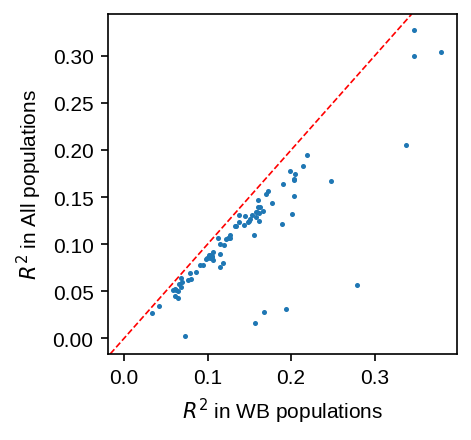

In [24]:
df_tmp = (
    df_trait_info.set_index("id")
    .loc[trait_list, :][["description", "group"]]
    .rename(columns={"description": "Trait", "group": "Category"})
)
for group in ["WB", "All"]:
    df_tmp[f"{group} N"] = 0
    df_tmp[f"{group} R2"] = 0

for trait in tqdm(df_tmp.index):
    # include number of testing individuals
    df_trait = pd.read_csv(
        os.path.join(f"../compile-data/out/per-trait-info/{trait}.tsv.gz"),
        index_col=0,
        sep="\t",
        usecols=["indiv", "group"],
    )
    n_wb = np.sum(df_trait.group == "United Kingdom")
    # n_diverse = np.sum(~(df_trait.group == "United Kingdom"))
    n_all = df_trait.shape[0]
    df_tmp.loc[trait, "WB N"] = n_wb
    df_tmp.loc[trait, "All N"] = n_all

    # include testing R2
    df_tmp.loc[trait, "WB R2"] = df_baseline_wb[trait]
    df_tmp.loc[trait, "All R2"] = df_baseline_all[trait]

df_tmp.to_excel("results/trait_info.xlsx", index=True, float_format="%.4f")

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(df_tmp["WB R2"], df_tmp["All R2"], s=2)
ax.axline((0, 0), slope=1, color="red", lw=0.8, ls="--")
ax.set_xlabel("$R^2$ in WB populations")
ax.set_ylabel("$R^2$ in All populations")

##### white
Bonferroni: 4.8e-05, FDR: 0.0042
covariates x traits: (13, 80)
## bonferroni < 0.05
# Significant pairs = 49 (4.7%)
# PGSs with at least one significant covariate: 29
--------------------------------------------------
## fdr < 0.05
# Significant pairs = 102 (9.8%)
# PGSs with at least one significant covariate: 52
--------------------------------------------------
##################################################
##### other
Bonferroni: 4.8e-05, FDR: 0.032
covariates x traits: (13, 80)
## bonferroni < 0.05
# Significant pairs = 416 (40%)
# PGSs with at least one significant covariate: 77
--------------------------------------------------
## fdr < 0.05
# Significant pairs = 677 (65%)
# PGSs with at least one significant covariate: 79
--------------------------------------------------
##################################################
##### all
Bonferroni: 4.8e-05, FDR: 0.033
covariates x traits: (13, 80)
## bonferroni < 0.05
# Significant pairs = 418 (40%)
# PGSs with at le

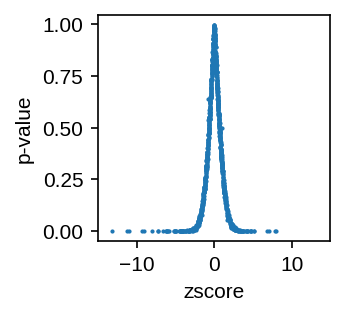

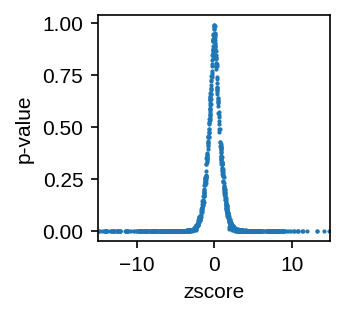

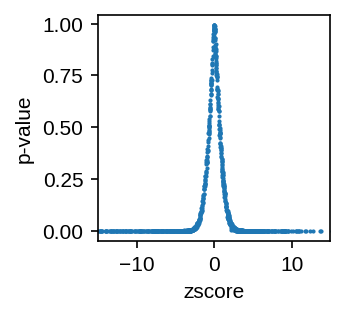

In [7]:
df_numerical = []
for group in ["white", "other", "all"]:
    df_baseline, df_diff, df_diff_pval, df_diff_zscore = load_r2_result(
        result_dir=f"out/", group=group
    )

    df_baseline, df_diff, df_diff_pval, df_diff_zscore = (
        df_baseline[trait_list],
        df_diff.loc[covar_list, trait_list],
        df_diff_pval.loc[covar_list, trait_list],
        df_diff_zscore.loc[covar_list, trait_list],
    )

    ## make numerical values
    df_tmp1 = (
        df_diff.loc[covar_list, trait_list]
        .rename(index=covar_map, columns=trait_map)
        .reset_index()
        .melt(id_vars=["group"], value_name="R2_reldiff")
    )

    df_tmp2 = (
        df_diff_zscore.loc[covar_list, trait_list]
        .rename(index=covar_map, columns=trait_map)
        .reset_index()
        .melt(id_vars=["group"], value_name="R2_reldiff_z")
    )
    assert np.all(df_tmp1[["group", "trait"]] == df_tmp2[["group", "trait"]])
    df_tmp = pd.merge(df_tmp1, df_tmp2, on=["group", "trait"]).rename(
        columns={"group": "covar"}
    )
    df_tmp["group"] = group
    df_tmp = df_tmp[["group", "trait", "covar", "R2_reldiff", "R2_reldiff_z"]].merge(
        df_baseline.rename(index=trait_map).rename("R2_baseline"),
        left_on="trait",
        right_index=True,
    )
    df_numerical.append(df_tmp)

    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    ax.scatter(df_diff_zscore.values.flatten(), df_diff_pval.values.flatten(), s=1)
    ax.set_xlim(-15, 15)
    ax.set_xlabel("zscore")
    ax.set_ylabel("p-value")

    df_pval = df_diff_zscore.applymap(lambda x: zsc2pval(x))
    pvals = df_pval.values.flatten()
    bonferroni_threshold = pvals[
        multipletests(pvals, method="bonferroni")[1] <= 0.05
    ].max()
    fdr_threshold = pvals[multipletests(pvals, method="fdr_bh")[1] <= 0.05].max()
    print(f"##### {group}")
    print(f"Bonferroni: {bonferroni_threshold:.2g}, FDR: {fdr_threshold:.2g}")

    print(f"covariates x traits: {df_pval.shape}")
    for name, thresh in zip(
        ["bonferroni", "fdr"], [bonferroni_threshold, fdr_threshold]
    ):
        print(f"## {name} < 0.05")
        n_signif = (df_pval.values.flatten() <= thresh).sum()
        print(
            f"# Significant pairs = {n_signif} ({n_signif / df_diff_pval.size * 100:.2g}%)"
        )

        print(
            f"# PGSs with at least one significant covariate:",
            np.any(df_pval <= thresh, axis=0).sum(),
        )
        print("-" * 50)
    print("#" * 50)
df_numerical = pd.concat(df_numerical)

df_numerical.to_excel("results/ukb-r2.xlsx", index=False, float_format="%.4f")

# Notable examples

In [11]:
plot_pairs = [
    #  Replicate Mostafavi et al.
    ("diastolic_BP", "SEX"),
    ("log_BMI", "AGE"),
    ("years_of_edu", "DEPRIVATION_INDEX"),
]

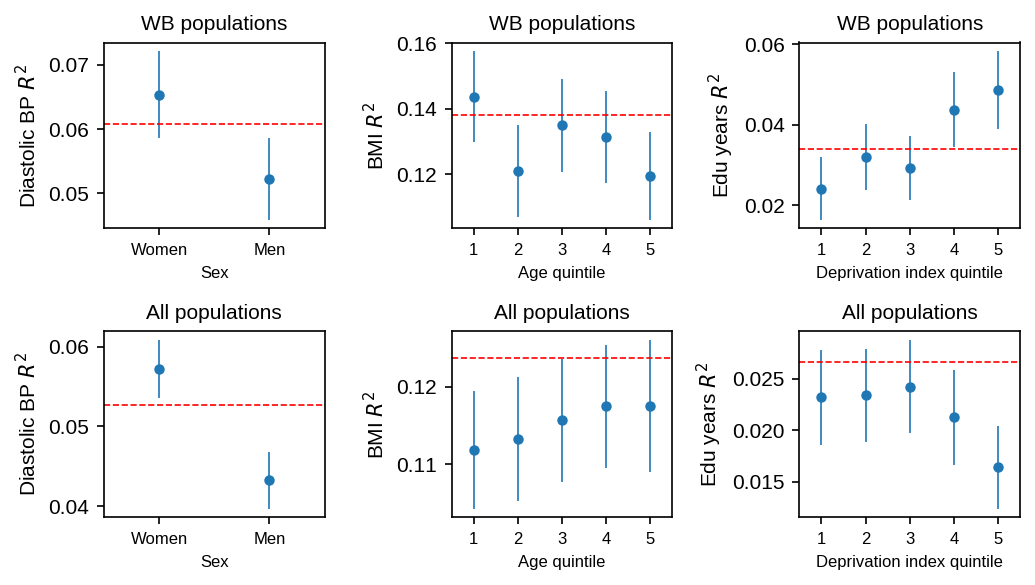

In [12]:
fig, axes = plt.subplots(figsize=(7, 4), dpi=150, nrows=2, ncols=len(plot_pairs))
for i, (trait, covar) in enumerate(plot_pairs):
    for j, group in enumerate(["white", "all"]):
        df_r2 = pd.read_csv(f"out/r2-diff/{trait}-{group}.r2.tsv", sep="\t")
        df_r2 = df_r2[df_r2.group == covar]
        baseline_r2 = pd.read_csv(
            f"out/r2-diff/{trait}-{group}.baseline.tsv",
            sep="\t",
            index_col=0,
            header=None,
            squeeze=True,
        )["r2"]
        ax = axes[j, i]
        ax.errorbar(
            x=np.arange(len(df_r2)),
            y=df_r2["r2"],
            yerr=df_r2["r2_se"] * 1.96,
            fmt=".",
            markersize=8,
            lw=0.8,
        )
        ax.axhline(y=baseline_r2, color="red", lw=0.8, ls="--")
        ax.set_xlim(-0.5, len(df_r2) - 0.5)
        ax.set_ylabel(f"{trait_map[trait]} $R^2$")
        ax.set_xticks(np.arange(len(df_r2)))
        if group == "white":
            ax.set_title("WB populations", fontsize=10)
        else:
            ax.set_title("All populations", fontsize=10)

        if covar == "SEX":
            xticklabels = ["Women", "Men"]
            xlabel = "Sex"
        else:
            xticklabels = np.arange(len(df_r2)) + 1
            xlabel = covar_map[covar] + " quintile"
        ax.set_xlabel(xlabel, fontsize=8)
        ax.set_xticklabels(xticklabels, fontsize=8)

plt.tight_layout()
plt.savefig("results/supp-r2-replicate.pdf", bbox_inches="tight")

In [13]:
df_baseline, df_diff, df_diff_pval, df_diff_zscore = load_r2_result(
    result_dir=f"out/", group="white"
)

for trait, covar in plot_pairs:
    print(
        f"{trait}, {covar}: relative R2 diff = {df_diff.loc[covar, trait]:.2g} (z = {df_diff_zscore.loc[covar, trait]:.2g})"
    )

diastolic_BP, SEX: relative R2 diff = -0.22 (z = -2.9)
log_BMI, AGE: relative R2 diff = -0.18 (z = -2.8)
years_of_edu, DEPRIVATION_INDEX: relative R2 diff = 0.72 (z = 3.3)
